<div class="alert alert-block alert-info">
<b>Deadline:</b> May 4, 2022 (Wednesday) 23:00
</div>

# Exercise 1. Generative adversarial networks (GANs). DCGAN: Deep convolutional GAN

The goal of this exercise is to get familiar with generative adversarial networks and specifically DCGAN. The model was proposed by [Radford et al., 2015](https://arxiv.org/pdf/1511.06434.pdf).

DCGAN is probably the simplest GAN model which is relatively easy to train.

In [1]:
skip_training = True  # Set this flag to True before validation and submission

In [2]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

import tools, warnings
warnings.showwarning = tools.customwarn

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

import torch
import torchvision
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms

import tools
import tests

In [4]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is /coursedata


In [5]:
#device = torch.device('cuda:0')
device = torch.device('cpu')
if torch.cuda.is_available():
    device = "cuda:0"

In [6]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

# Data

We will use MNIST data in this exercise. **Note that we re-scale images so that the pixel intensities are in the range [-1, 1].**

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Normalize((0.5,), (0.5,))  # Scale images to [-1, 1]
])

trainset = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)

batch_size = 100
dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Generative adversarial networks

Our task is to train a generative model of the data, that is a model from which we can draw samples that will have a distribution similar to the distribution of the training data (MNIST digits in our case).

## Generator

The generative model that we are going to train is:
\begin{align}
z &\sim N(0, I)
\\
x &= g(z)
\end{align}
that is the data is generated by applying a nonlinear transformation to samples drawn from the standard normal distribution.

We are going to model $g$ with a deep neural network created below. In DCGAN, the generator is made of only transposed convolutional layers `ConvTranspose2d`.
The proposed architecture for the generator:
* `ConvTranspose2d` layer with `kernel_size=4`, `stride=2`, `4*ngf` output channels, no bias,
   followed by `BatchNorm2d` and ReLU
* `ConvTranspose2d` layer with `kernel_size=4`, `stride=2`, `2*ngf` output channels, no bias,
   followed by `BatchNorm2d` and ReLU
* `ConvTranspose2d` layer with `kernel_size=4`, `stride=2`, `ngf` output channels, no bias,
   followed by `BatchNorm2d` and ReLU
* `ConvTranspose2d` layer with `kernel_size=4`, `stride=2`, `nc` output channels, no bias,
   followed by `tanh`.

The `tanh` nonlinearity guarantees that the output is between -1 and 1 which holds for our scaling of the training data.

* **The exact architecture is not tested in this assignment.**
* **The description above is not full. To get the correct output shape, you need to set correctly other parameters of the `ConvTranspose2d` layers. Note that training may fail for some padding schemes. If training fails but everything else looks correct, try changing the padding scheme.**

In [8]:
class Generator(nn.Module):
    def __init__(self, nz=10, ngf=64, nc=1, padding_scheme = [0,0,1,7]):
        """GAN generator.
        
        Args:
          nz:  Number of elements in the latent code.
          ngf: Base size (number of channels) of the generator layers.
          nc:  Number of channels in the generated images.
        """
        super(Generator, self).__init__()
        self.layer1 = nn.Sequential(nn.ConvTranspose2d(in_channels = nz, out_channels = 4*ngf, bias = False, kernel_size=4, stride=2,
                                                    padding = padding_scheme[0]),
                                    nn.BatchNorm2d(4*ngf),
                                    nn.ReLU())
        self.layer2 = nn.Sequential(nn.ConvTranspose2d(in_channels = 4*ngf, out_channels = 2*ngf, bias = False, kernel_size=4, stride=2,
                                                    padding = padding_scheme[1]),
                                    nn.BatchNorm2d(2*ngf),
                                    nn.ReLU())
        self.layer3 = nn.Sequential(nn.ConvTranspose2d(in_channels = 2*ngf, out_channels = ngf, bias = False, kernel_size=4, stride=2,
                                                    padding = padding_scheme[2]),
                                    nn.BatchNorm2d(ngf),
                                    nn.ReLU())
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(in_channels = ngf, out_channels = nc, bias = False, kernel_size=4, stride=2,
                                                    padding = padding_scheme[3]),
                                    nn.Tanh()
                                )

    def forward(self, z, verbose=False):
        """Generate images by transforming the given noise tensor.
        
        Args:
          z of shape (batch_size, nz, 1, 1): Tensor of noise samples. We use the last two singleton dimensions
                          so that we can feed z to the generator without reshaping.
          verbose (bool): Whether to print intermediate shapes (True) or not (False).
        
        Returns:
          out of shape (batch_size, nc, 28, 28): Generated images.
        """
        ret = self.layer1(z)
        if verbose: 
            (print("layer1:",ret.shape))
        ret = self.layer2(ret)
        if verbose: 
            (print("layer2:",ret.shape))
        ret = self.layer3(ret)
        if verbose: 
            (print("layer3:",ret.shape))
        ret = self.layer4(ret)
        if verbose: 
            (print("layer4:",ret.shape))
        return ret

In [9]:
def test_Generator_shapes():
    nz = 10
    netG = Generator(nz, ngf=64, nc=1)

    batch_size = 32
    noise = torch.randn(batch_size, nz, 1, 1)
    out = netG(noise, verbose=True)

    assert out.shape == torch.Size([batch_size, 1, 28, 28]), f"Bad shape of out: out.shape={out.shape}"
    print('Success')

test_Generator_shapes()

layer1: torch.Size([32, 256, 4, 4])
layer2: torch.Size([32, 128, 10, 10])
layer3: torch.Size([32, 64, 20, 20])
layer4: torch.Size([32, 1, 28, 28])
Success


### Loss for training the generator

The generative model will be guided by a discriminator whose task is to separate (classify) data into two classes:
* true data (samples from the training set)
* generated data (samples generated by the generator).

In [10]:
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

The task of the generator is to confuse the discriminator as much as possible, which is the case when the distribution produced by the generator perfectly replicates the data distribution.

In the cell below, you need to implement the loss function which is used to train the generator. The loss should be the `binary_cross_entropy` loss computed with `real_label` as targets for the generated samples.

**IMPORTANT: Please use the `mean` reduction when computing the loss!**

In [11]:
def generator_loss(netD, fake_images):
    """Loss computed to train the GAN generator.

    Args:
      netD: The discriminator whose forward function takes inputs of shape (batch_size, nc, 28, 28)
         and produces outputs of shape (batch_size, 1).
      fake_images of shape (batch_size, nc, 28, 28): Fake images produces by the generator.

    Returns:
      loss: The mean of the binary cross-entropy losses computed for all the samples in the batch.

    Notes:
    - Make sure that you process on the device given by `fake_images.device`.
    - Use values of global variables `real_label`, `fake_label` to produce the right targets.
    """
    guesses = netD(fake_images)
    criterion = nn.BCELoss()
    targets = torch.full_like(guesses, fill_value = real_label).to(fake_images.device)
    loss_vec = criterion(guesses, targets)
    loss = torch.mean(loss_vec)
    return loss

In [12]:
# This cell tests generator_loss()

## Discriminator

In DCGAN, the discriminator is a stack of only convolutional layers.

The proposed architecture for the discriminator:
* `Conv2d` layer with `kernel_size=4`, `stride=2`, `ndf` output channels, no bias,
   followed by BatchNorm2d and LeakyReLU(0.2)
* `Conv2d` layer with `kernel_size=4`, `stride=2`, `2*ndf` output channels, no bias,
   followed by BatchNorm2d and LeakyReLU(0.2)
* `Conv2d` layer with `kernel_size=4`, `stride=2`, `4*ndf` output channels, no bias,
   followed by BatchNorm2d and LeakyReLU(0.2)
* `Conv2d` layer with `kernel_size=4`, `stride=2`, 1 output channel, no bias,
   followed by `sigmoid`.

Notes:
* **The exact architecture is not tested in this assignment.**
* **The description is not full, please fill the missing pieces by yourself.**
* In this exercise, the discriminator works well without batch normalization layers.

In [13]:
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=64, padding_scheme = [1,0,0,1]):
        """GAN discriminator.
        
        Args:
          nc:  Number of channels in images.
          ndf: Base size (number of channels) of the discriminator layers.
        """
        super(Discriminator, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels = nc, out_channels = ndf, bias = False, kernel_size=4, stride=2,
                                                    padding = padding_scheme[0]),
                                    nn.BatchNorm2d(ndf),
                                    nn.LeakyReLU(0.2)
                                    )
        self.layer2 = nn.Sequential(nn.Conv2d(in_channels = ndf, out_channels = 2*ndf, bias = False, kernel_size=4, stride=2,
                                                    padding = padding_scheme[1]),
                                    nn.BatchNorm2d(2*ndf),
                                    nn.LeakyReLU(0.2)
                                    )
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels = 2*ndf, out_channels = 4*ndf, bias = False, kernel_size=4, stride=2,
                                                    padding = padding_scheme[2]),
                                    nn.BatchNorm2d(4*ndf),
                                    nn.LeakyReLU(0.2)
                                    )
        self.layer4 = nn.Sequential(nn.Conv2d(in_channels = 4*ndf, out_channels = 1, bias = False, kernel_size=4, stride=2,
                                                    padding = padding_scheme[3]),
                                    nn.Sigmoid()
                                )

    def forward(self, x, verbose=False):
        """Classify given images into real/fake.
        
        Args:
          x of shape (batch_size, 1, 28, 28): Images to be classified.
        
        Returns:
          out of shape (batch_size,): Probabilities that images are real. All elements should be between 0 and 1.
        """
        ret = self.layer1(x)
        if verbose: 
            (print("layer1:",ret.shape))
        ret = self.layer2(ret)
        if verbose: 
            (print("layer2:",ret.shape))
        ret = self.layer3(ret)
        if verbose: 
            (print("layer3:",ret.shape))
        ret = self.layer4(ret)
        if verbose: 
            (print("layer4:",ret.shape))
        ret = ret.view(-1)
        if verbose: 
            (print("final output:",ret.shape))
        return ret

In [14]:
def test_Discriminator_shapes():
    batch_size = 32
    netD = Discriminator(nc=1, ndf=64)

    images = torch.ones(32, 1, 28, 28)
    out = netD(images, verbose=True)

    assert out.shape == torch.Size([batch_size]), f"Bad shape of out: out.shape={out.shape}"
    print('Success')

test_Discriminator_shapes()

layer1: torch.Size([32, 64, 14, 14])
layer2: torch.Size([32, 128, 6, 6])
layer3: torch.Size([32, 256, 2, 2])
layer4: torch.Size([32, 1, 1, 1])
final output: torch.Size([32])
Success


### Loss for training the discriminator

The discriminator is trained to solve a binary classification problem: to separate real data from generated samples. Thus, the output of the discriminator should be a scalar between 0 and 1.

You need to implement the loss function used to train the discriminator. The dicriminator uses the `binary_cross_entropy` loss using `real_label` as targets for real samples and `fake_label` as targets for generated samples.

**IMPORTANT: Please use the `mean` reduction when computing the loss!**

In [15]:
def discriminator_loss(netD, real_images, fake_images):
    """Loss computed to train the GAN discriminator.

    Args:
      netD: The discriminator.
      real_images of shape (batch_size, nc, 28, 28): Real images.
      fake_images of shape (batch_size, nc, 28, 28): Fake images produces by the generator.

    Returns:
      d_loss_real: The mean of the binary cross-entropy losses computed on the real_images.
      D_real: Mean output of the discriminator for real_images. This is useful for tracking convergence.
      d_loss_fake: The mean of the binary cross-entropy losses computed on the fake_images.
      D_fake: Mean output of the discriminator for fake_images. This is useful for tracking convergence.

    Notes:
    - Make sure that you process on the device given by `fake_images.device`.
    - Use values of global variables `real_label`, `fake_label` to produce the right targets.
    """
    guesses_real = netD(real_images)
    guesses_fake = netD(fake_images)
    criterion_real = nn.BCELoss()
    criterion_fake =  nn.BCELoss()
    
    target_real = torch.full_like(guesses_real, fill_value = real_label).to(fake_images.device)
    d_loss_real_vec = criterion_real(guesses_real, target_real)#.to(fake_images.device)
    d_loss_real = torch.mean(d_loss_real_vec)
    D_real = torch.mean(guesses_real)
    
    target_fake = torch.full_like(guesses_fake, fill_value = fake_label).to(fake_images.device)
    d_loss_fake_vec = criterion_fake(guesses_fake, target_fake)#.to(fake_images.device)
    d_loss_fake = torch.mean(d_loss_fake_vec)
    D_fake = torch.mean(guesses_fake)
    
    return d_loss_real, D_real, d_loss_fake, D_fake
    

In [16]:
def test_discriminator_loss():
    netD = Discriminator(nc=1, ndf=64)
    real_images = fake_images = torch.ones(32, 1, 28, 28)

    d_loss_real, D_real, d_loss_fake, D_fake = discriminator_loss(netD, real_images, fake_images)
    assert d_loss_real.shape == torch.Size([]), "d_loss_real should be a scalar tensor."
    assert 0 < D_real < 1, "D_real should be a scalar between 0 and 1."
    assert d_loss_fake.shape == torch.Size([]), "d_loss_fake should be a scalar tensor."
    assert 0 < D_fake < 1, "D_fake should be a scalar between 0 and 1."
    print('Success')

test_discriminator_loss()

Success


In [17]:
# This cell tests discriminator_loss()

# Evaluation of quality of generated samples

We would like to evaluate the quality of the generated samples using some metric. Designing such a metric is not a trivial task. The most popular metric for assessing the quality of generated images is Fréchet Inception Distance (FID) [(Heusel et al., 2017)](https://arxiv.org/abs/1706.08500). The FID score compares the distribution of intermediate activations when real or generated samples are passed through an Inception network. The Inception network is a specific type of a convolutional neural network that is pre-trained on image classification tasks.

In this exercise, we do not generate natural images and therefore we do not use the Inception network to compute the activations. Instead, we use a simple convolutional neural network trained to classify MNIST digits. Therefore, we call the metric FD score (dropping the word *Inception*).

In [18]:
import fd

# Load an FD scorer pre-trained on MNIST
fdscore = fd.FDScore.pretrained()
fdscore.to(device)

FDScore(
  (net): Classifier(
    (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=512, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [19]:
# Score on uniform noise in the range [-1, 1]
samples = torch.rand(10000, 1, 28, 28).to(device)
samples = (samples - 0.5) * 2
score = fdscore.calculate(samples)
print(f'Score on Gaussian noise: {score:.5f}')

Score on Gaussian noise: 515.97949


In [20]:
# Score on real MNIST digits
samples = torch.stack([testset[i][0] for i in range(10000)]).to(device)
score = fdscore.calculate(samples)
print(f'Score on MNIST: {score:.5f}')

Score on MNIST: 0.80417


# Training GANs

We will now train a GAN. To assess the quality of the generated samples, we will use a simple scorer loaded in the cell below.

In [21]:
# Create the network
nz = 10
netG = Generator(nz=nz, ngf=64, nc=1)
netD = Discriminator(nc=1, ndf=64)

netD = netD.to(device)
netG = netG.to(device)

### Training loop

Implement the training loop in the cell below. The recommended hyperparameters:
* Optimizer of the discriminator: Adam with learning rate 0.0002 and `betas=(0.5, 0.999)`
* Optimizer of the generator:     Adam with learning rate 0.0002 and `betas=(0.5, 0.999)`

Hints:
- We will use the FD score to assess the quality of the generated samples. Your GAN should have the FD score below 10. This level can be reached after 5 epochs. Note that the score is stochastic and it can fluctuate during training. At convergence, the FD score can fluctuate in the range [3, 9].
- You can use the following code to track the training progress. The code plots some generated images and computes the score that we use to evaluate the trained model. Note that the images fed to the scorer need to be normalized to be in the range [-1, 1].
```python
with torch.no_grad():
    # Plot generated images
    z = torch.randn(144, nz, 1, 1, device=device)
    samples = netG(z)
    tools.plot_generated_samples(samples)
    
    # Compute score
    z = torch.randn(1000, nz, 1, 1, device=device)
    samples = netG(z)
    score = fdscore.calculate(samples)
```
- You can track `D_real` and `D_fake` returned by function `discriminator_loss()`. When it is hard for the discriminator to separate real and fake images, their values are close to 0.5.

In [22]:
if not skip_training:
  import time
  import psutil
  import ray
  from ray import tune
  from ray.tune import JupyterNotebookReporter
  from ray.tune.schedulers import ASHAScheduler
  from ray.tune.stopper import TrialPlateauStopper
  ray._private.utils.get_system_memory = lambda: psutil.virtual_memory().total
  gpu_count = 0
  if torch.cuda.is_available():
      gpu_count = torch.cuda.device_count()
      if gpu_count > 1:
          netD = nn.DataParallel(netD)
          netG = nn.DataParallel(netG)

In [23]:
if not skip_training:

    possible_schemes= [[1,0,0,1], #16+2
                       [0,2,0,1], #8+8+2
                       [0,1,2,1], #8+4+4+2
                       [0,1,1,3], #8+4+2+2+2
                       [0,1,0,5], #8+5*2
                       [0,0,4,1], #4*4+2
                       [0,0,3,3], #3*4+3*2
                       [0,0,2,5], #4+4+2*5
                       [0,0,1,7], #4+7*2
                       [0,0,0,9]] #9*2
    
    def print_error(epoch, score, start):
        current = time.time()
        print(f"Epoch {epoch}: FD score is {np.round(score, decimals = 2)}")
        print(f"         after { int((current - start)/60)}min { int((current - start)%60)}s")
    

    
    def training_loop(hyperparameters, tune_mode = True):
      epochs = 5

      G_losses = []
      D_losses = []
      Sum_losses = []
      
      nz = 10
      netG = Generator(nz=nz, ngf=64, nc=1, padding_scheme = hyperparameters["G_scheme"])
      netD = Discriminator(nc=1, ndf=64, padding_scheme = hyperparameters["D_scheme"])

      netD = netD.to(device)
      netG = netG.to(device)

      G_params = netG.parameters()
      D_params = netD.parameters()
      G_optimizer = torch.optim.Adam(G_params, lr=0.0002, betas = (0.5, 0.999))
      D_optimizer = torch.optim.Adam(D_params, lr=0.0002, betas = (0.5, 0.999))

      start = time.time()

      for i in range(epochs):
          netG.train()
          netD.train()

          for targets, labels in dataloader:
              targets = targets.to(device)
              batch_size = targets.shape[0]

              D_optimizer.zero_grad()
              noise = torch.randn(size = (batch_size,nz,1,1)).to(device)
              generated_images = netG(noise).to(device)
              d_loss_real, D_real, d_loss_fake, D_fake = discriminator_loss(netD = netD, real_images = targets, fake_images = generated_images)
              D_loss = sum([d_loss_real, d_loss_fake])
              D_loss.backward()
              D_optimizer.step() 
              
              G_optimizer.zero_grad()
              noise = torch.randn(size = (batch_size,nz,1,1)).to(device)
              generated_images = netG(noise).to(device)
              G_loss = generator_loss(netD, generated_images)
              G_loss.backward()
              G_optimizer.step()
              G_losses.append(G_loss.item())
              D_losses.append(D_loss.item())

          
          with torch.no_grad():
              # Compute score
              z = torch.randn(1000, nz, 1, 1, device=device)
              samples = netG(z)
              score = fdscore.calculate(samples)
  
              if tune_mode:
                tune.report(FDscore = score,
                            G_Loss = G_loss.item(),
                            D_loss = D_loss.item(),
                            Epoch = i+1,
                            Elapsed_time = f"{ int((time.time() - start)/60)}min { int((time.time() - start)%60)}s",
                            D_fake = D_fake,
                            D_real = D_real)
                tools.save_model(netG, './1_dcgan_g.pth', confirm=False)
                tools.save_model(netD, './1_dcgan_d.pth', confirm=False)
              else:

                # Plot generated images
                z = torch.randn(144, nz, 1, 1, device=device)
                samples = netG(z)
                tools.plot_generated_samples(samples)

                print_error(i+1, score, start)
      if not tune_mode:
        plt.figure(figsize=(10,5))
        plt.title("Generator and Discriminator Loss During Training")
        plt.plot(G_losses,label="G")
        plt.plot(D_losses,label="D")
        #plt.plot(Sum_losses,label="Sum")
        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    
    config = {
    "G_scheme": tune.choice(possible_schemes),
    "D_scheme": tune.choice(possible_schemes)}
    
    scheduler = ASHAScheduler(
        metric="FDscore",
        mode="min",
        grace_period = 3)
    
    reporter = JupyterNotebookReporter(
        metric_columns=["FDscore", "G_Loss", "D_loss", "D_fake", "D_real", "Epoch", "Elapsed_time"],
        overwrite = True,
        print_intermediate_tables = True,
        sort_by_metric = True,
        metric = "FDscore",
        mode = "min")
    
    stopper = TrialPlateauStopper(metric = 'FDscore',
                                  std = 10,
                                  num_results= 3)
    
    # result  = tune.run(run_or_experiment  = training_loop,
    #                    config = config,
    #                    #metric = "validation_error",
    #                    #mode = "min",
    #                    num_samples=20,
    #                    resources_per_trial = {"gpu": gpu_count/2, "cpu": (torch.get_num_threads()/2)},
    #                    verbose = 1,
    #                    scheduler = scheduler,
    #                    progress_reporter=reporter,
    #                    stop=stopper,
    #                    name = "DCGAN")
                       
    # best_trial = result.get_best_trial("FDscore", "min", "last")
    # if(best_trial):
    #     print("Best trial config: {}".format(best_trial.config))
    #     print("Best trial final FDscore: {}".format(
    #         best_trial.last_result["FDscore"]))
    # else:
    #     print("No best trial")
    # end = time.time()
    #print("Training done")
    #print(f"Time needed: { int((end - start)/60)}min { int((end - start)%60)}s")

    


In [24]:
# if not skip_training:
#   df = result.results_df
#   logdir = result.get_best_logdir("FDscore", mode="min")
#   best_config = result.get_best_config(metric = "FDscore", mode="min")
#   D_state_dict = torch.load(os.path.join(logdir, "1_dcgan_d.pth"))
#   G_state_dict = torch.load(os.path.join(logdir, "1_dcgan_g.pth"))

#   netG = Generator(nz=nz, ngf=64, nc=1, padding_scheme = best_config["G_scheme"])
#   netD = Discriminator(nc=1, ndf=64, padding_scheme = best_config["D_scheme"])

#   netD = netD.to(device)
#   netG = netG.to(device)
  
#   netD.load_state_dict(D_state_dict)
#   netG.load_state_dict(G_state_dict)

In [25]:
if not skip_training:
    epochs = 5

    G_losses = []
    D_losses = []
    Sum_losses = []

    nz = 10
    netG = Generator(nz=nz, ngf=64, nc=1, padding_scheme = [0,0,1,7])
    netD = Discriminator(nc=1, ndf=64, padding_scheme = [0,0,1,7])

    netD = netD.to(device)
    netG = netG.to(device)

    G_params = netG.parameters()
    D_params = netD.parameters()
    G_optimizer = torch.optim.Adam(G_params, lr=0.0002, betas = (0.5, 0.999))
    D_optimizer = torch.optim.Adam(D_params, lr=0.0002, betas = (0.5, 0.999))



    for i in range(epochs):
      netG.train()
      netD.train()

      for targets, labels in dataloader:
          targets = targets.to(device)
          batch_size = targets.shape[0]

          D_optimizer.zero_grad()
          noise = torch.randn(size = (batch_size,nz,1,1)).to(device)
          generated_images = netG(noise).to(device)
          d_loss_real, D_real, d_loss_fake, D_fake = discriminator_loss(netD = netD, real_images = targets, fake_images = generated_images)
          D_loss = sum([d_loss_real, d_loss_fake])
          D_loss.backward()
          D_optimizer.step() 

          G_optimizer.zero_grad()
          noise = torch.randn(size = (batch_size,nz,1,1)).to(device)
          generated_images = netG(noise).to(device)
          G_loss = generator_loss(netD, generated_images)
          G_loss.backward()
          G_optimizer.step()
          G_losses.append(G_loss.item())
          D_losses.append(D_loss.item())


      with torch.no_grad():
          # Compute score
          z = torch.randn(1000, nz, 1, 1, device=device)
          samples = netG(z)
          score = fdscore.calculate(samples)



          # Plot generated images
          z = torch.randn(144, nz, 1, 1, device=device)
          samples = netG(z)
          tools.plot_generated_samples(samples)

          print_error(i+1, score, start)
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    #plt.plot(Sum_losses,label="Sum")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [26]:
if skip_training:
    nz = 10
    netG = Generator(nz=nz, ngf=64, nc=1)
    netD = Discriminator(nc=1, ndf=64)

    tools.load_model(netG, '1_dcgan_g.pth', device)
    tools.load_model(netD, '1_dcgan_d.pth', device)

Model loaded from 1_dcgan_g.pth.
Model loaded from 1_dcgan_d.pth.


In [27]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
# Set confirm=False if you do not want to be asked for confirmation before saving.
if not skip_training:
    tools.save_model(netG, '1_dcgan_g.pth', confirm=False)
    tools.save_model(netD, '1_dcgan_d.pth', confirm=False)

## GAN evaluation

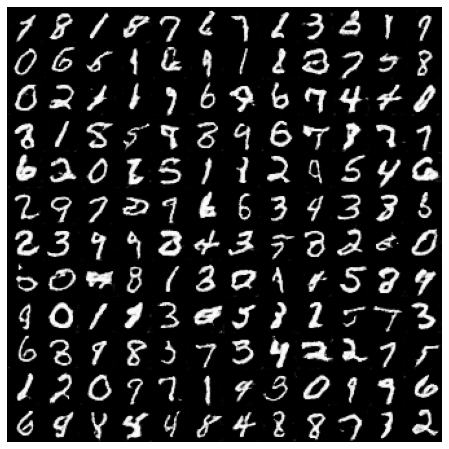

In [28]:
# Save generated samples (the pth-files will be submitted automatically together with your notebook)
if not skip_training:
    with torch.no_grad():
        z = torch.randn(144, nz, 1, 1, device=device)
        samples = netG(z)
        torch.save(samples, '1_dcgan_samples.pth')
else:
    samples = torch.load('1_dcgan_samples.pth', map_location=lambda storage, loc: storage)

tools.plot_generated_samples(samples)

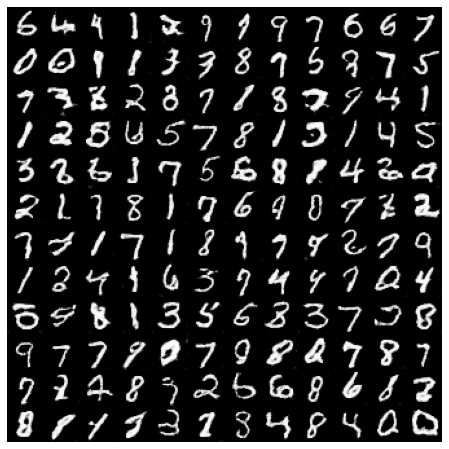

FD score: 8.03091


In [31]:
# Compute the FD score
torch.manual_seed(0)
with torch.no_grad():
    z = torch.randn(1000, nz, 1, 1, device=device)
    samples = netG(z)
    tools.plot_generated_samples(samples[:144])
    score = fdscore.calculate(samples)

print(f'FD score: {score:.5f}')

In [30]:
# This cell is used for grading

<div class="alert alert-block alert-info">
<b>Conclusion</b>
</div>

In this notebook, we learned how to train a simple GAN model for generating images.